# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


## Mobilenet_v2 - simple model

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [11]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_1 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='mobilenet_simple'
)

model_1.summary()

Model: "mobilenet_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 100
patience = 2

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 259s 4s/step - loss: 0.5564 - binary_accuracy: 0.6859 - val_loss: 0.4401 - val_binary_accuracy: 0.7272
Epoch 2/100
58/58 [==============================] - 249s 4s/step - loss: 0.3800 - binary_accuracy: 0.8196 - val_loss: 0.3580 - val_binary_accuracy: 0.8239
Epoch 3/100
58/58 [==============================] - 205s 4s/step - loss: 0.3277 - binary_accuracy: 0.8497 - val_loss: 0.3236 - val_binary_accuracy: 0.8522
Epoch 4/100
58/58 [==============================] - 207s 4s/step - loss: 0.3007 - binary_accuracy: 0.8690 - val_loss: 0.3025 - val_binary_accuracy: 0.8761
Epoch 5/100
58/58 [==============================] - 207s 4s/step - loss: 0.2814 - binary_accuracy: 0.8796 - val_loss: 0.2918 - val_binary_accuracy: 0.8620
Epoch 6/100
58/58 [==============================] - 208s 4s/step - loss: 0.2694 - binary_accuracy: 0.8878 - val_loss: 0.2776 - val_binary_accuracy: 0.8826
Epoch 7/100
58/58 [==============================] - 206s 4s/ste

58/58 [==============================] - 296s 5s/step - loss: 0.1200 - binary_accuracy: 0.9571 - val_loss: 0.1664 - val_binary_accuracy: 0.9250
Epoch 54/100
58/58 [==============================] - 305s 5s/step - loss: 0.1200 - binary_accuracy: 0.9584 - val_loss: 0.1658 - val_binary_accuracy: 0.9228
Epoch 55/100
58/58 [==============================] - 252s 4s/step - loss: 0.1171 - binary_accuracy: 0.9582 - val_loss: 0.1641 - val_binary_accuracy: 0.9304
Epoch 56/100
58/58 [==============================] - 253s 4s/step - loss: 0.1151 - binary_accuracy: 0.9614 - val_loss: 0.1654 - val_binary_accuracy: 0.9304
Epoch 57/100
58/58 [==============================] - 257s 4s/step - loss: 0.1152 - binary_accuracy: 0.9598 - val_loss: 0.1623 - val_binary_accuracy: 0.9228
Epoch 58/100
58/58 [==============================] - 254s 4s/step - loss: 0.1129 - binary_accuracy: 0.9639 - val_loss: 0.1614 - val_binary_accuracy: 0.9250
Epoch 59/100
58/58 [==============================] - 257s 4s/step - lo

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

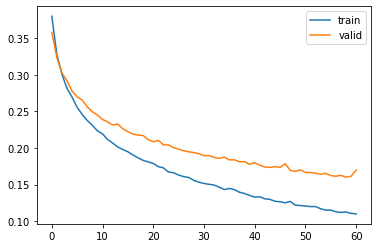

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

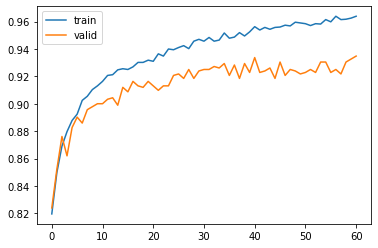

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.9375

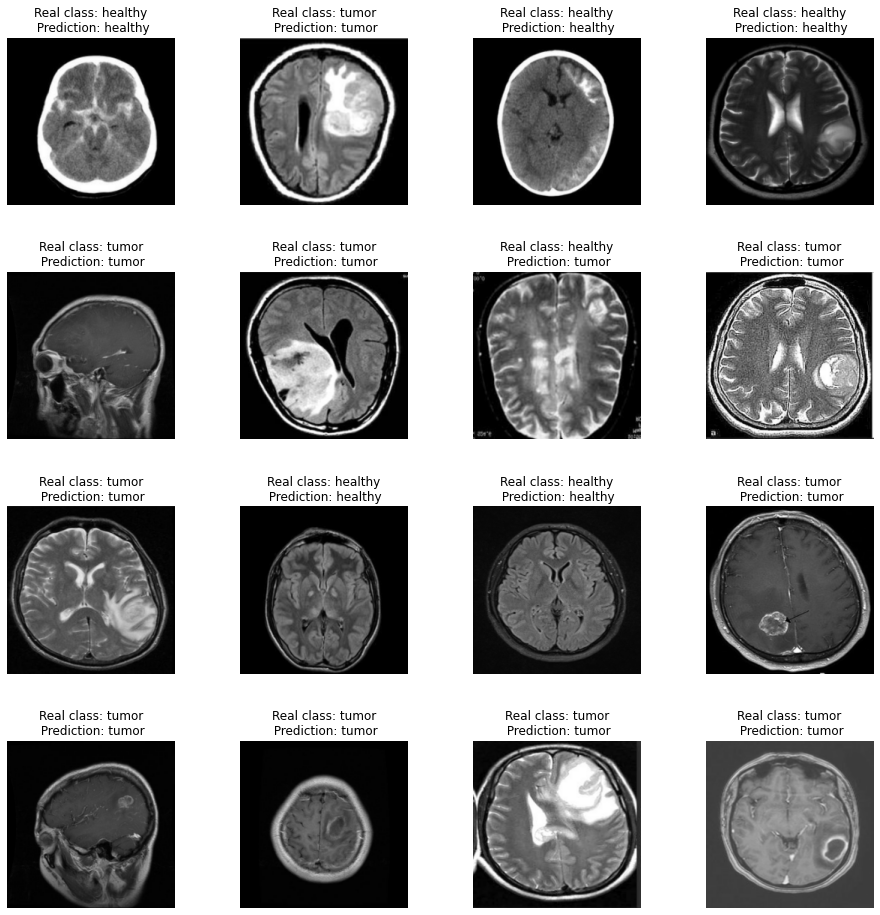

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')
plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

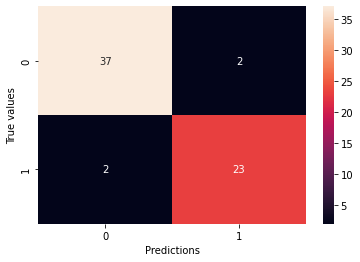

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.95      0.95      0.95        39
     Healthy       0.92      0.92      0.92        25

    accuracy                           0.94        64
   macro avg       0.93      0.93      0.93        64
weighted avg       0.94      0.94      0.94        64



## Mobilenet_v2 - model with data augmentation

In [23]:
input_shape = (224, 224, 3)

In [24]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_2 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='mobilenet_with_augmentation'
)

model_2.summary()

Model: "mobilenet_with_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 100
patience = 2

In [27]:
history_2 = model_2.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 290s 5s/step - loss: 0.6438 - binary_accuracy: 0.6147 - val_loss: 0.5454 - val_binary_accuracy: 0.7489
Epoch 2/100
58/58 [==============================] - 275s 5s/step - loss: 0.5239 - binary_accuracy: 0.7163 - val_loss: 0.4749 - val_binary_accuracy: 0.7174
Epoch 3/100
58/58 [==============================] - 274s 5s/step - loss: 0.4621 - binary_accuracy: 0.7701 - val_loss: 0.4319 - val_binary_accuracy: 0.7880
Epoch 4/100
58/58 [==============================] - 271s 5s/step - loss: 0.4441 - binary_accuracy: 0.7810 - val_loss: 0.4203 - val_binary_accuracy: 0.7761
Epoch 5/100
58/58 [==============================] - 273s 5s/step - loss: 0.4249 - binary_accuracy: 0.7908 - val_loss: 0.4044 - val_binary_accuracy: 0.7913
Epoch 6/100
58/58 [==============================] - 277s 5s/step - loss: 0.4079 - binary_accuracy: 0.8041 - val_loss: 0.4060 - val_binary_accuracy: 0.7793
Epoch 7/100
58/58 [==============================] - 269s 5s/ste

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

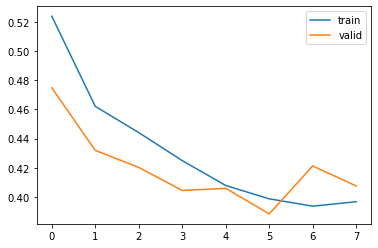

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

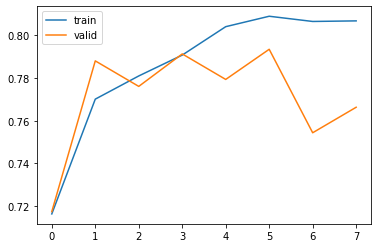

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [31]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.8125

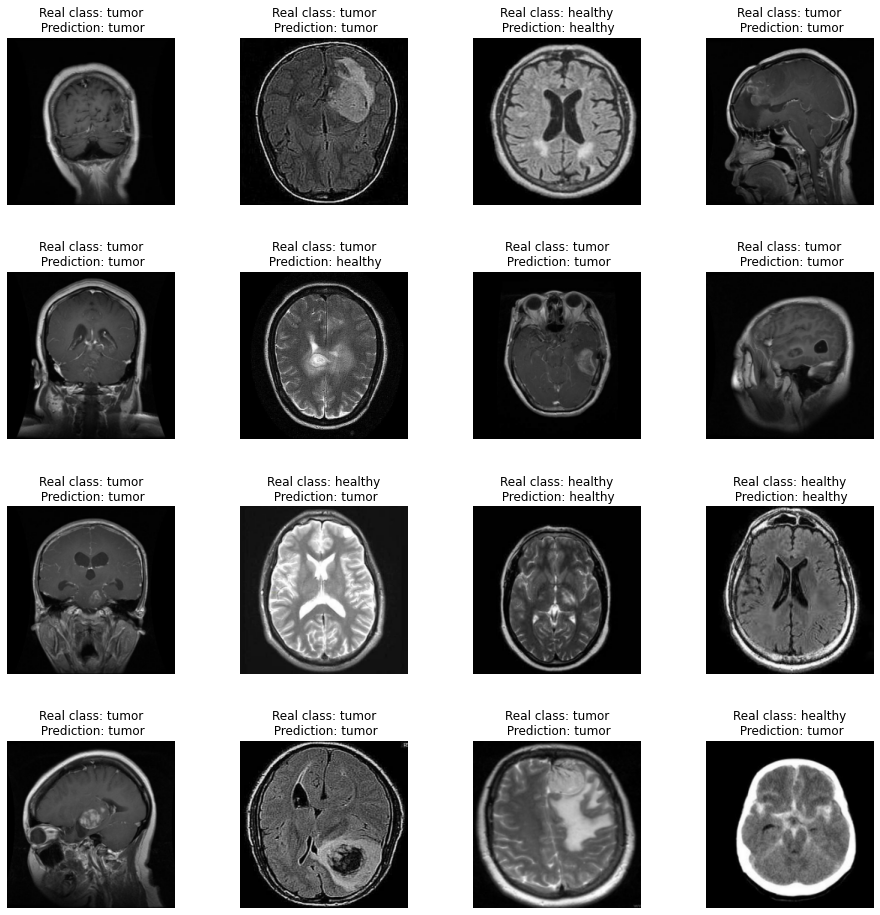

In [32]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [33]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

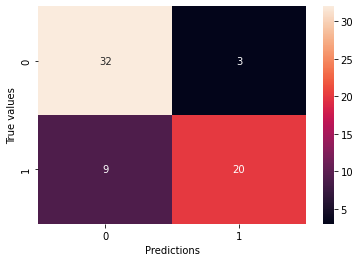

In [34]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [35]:
print(classification_report(y_val_2, y_pred_2_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.78      0.91      0.84        35
     Healthy       0.87      0.69      0.77        29

    accuracy                           0.81        64
   macro avg       0.83      0.80      0.81        64
weighted avg       0.82      0.81      0.81        64



## Mobilenet_v2 - model with data augmentation + additional layers

In [36]:
input_shape = (224, 224, 3)

In [37]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_3 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='mobilenet_with_additional_dense'
)

model_3.summary()

Model: "mobilenet_with_additional_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_1 (RandomCon (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation_1 (Random (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               409920    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None,

In [38]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [39]:
epochs = 100
patience = 5

In [40]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 295s 5s/step - loss: 1.1589 - binary_accuracy: 0.6617 - val_loss: 0.3980 - val_binary_accuracy: 0.8000
Epoch 2/100
58/58 [==============================] - 277s 5s/step - loss: 0.4645 - binary_accuracy: 0.7832 - val_loss: 0.4013 - val_binary_accuracy: 0.7783
Epoch 3/100
58/58 [==============================] - 274s 5s/step - loss: 0.4973 - binary_accuracy: 0.7783 - val_loss: 0.4065 - val_binary_accuracy: 0.7891
Epoch 4/100
58/58 [==============================] - 278s 5s/step - loss: 0.4004 - binary_accuracy: 0.8174 - val_loss: 0.4291 - val_binary_accuracy: 0.7707
Epoch 5/100
58/58 [==============================] - 273s 5s/step - loss: 0.3620 - binary_accuracy: 0.8348 - val_loss: 0.3727 - val_binary_accuracy: 0.8283
Epoch 6/100
58/58 [==============================] - 275s 5s/step - loss: 0.3640 - binary_accuracy: 0.8348 - val_loss: 0.3516 - val_binary_accuracy: 0.8370
Epoch 7/100
58/58 [==============================] - 278s 5s/ste

In [41]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

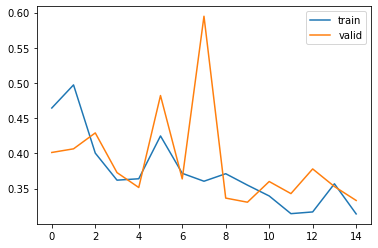

In [42]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

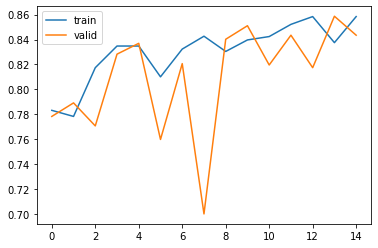

In [43]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [44]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.90625

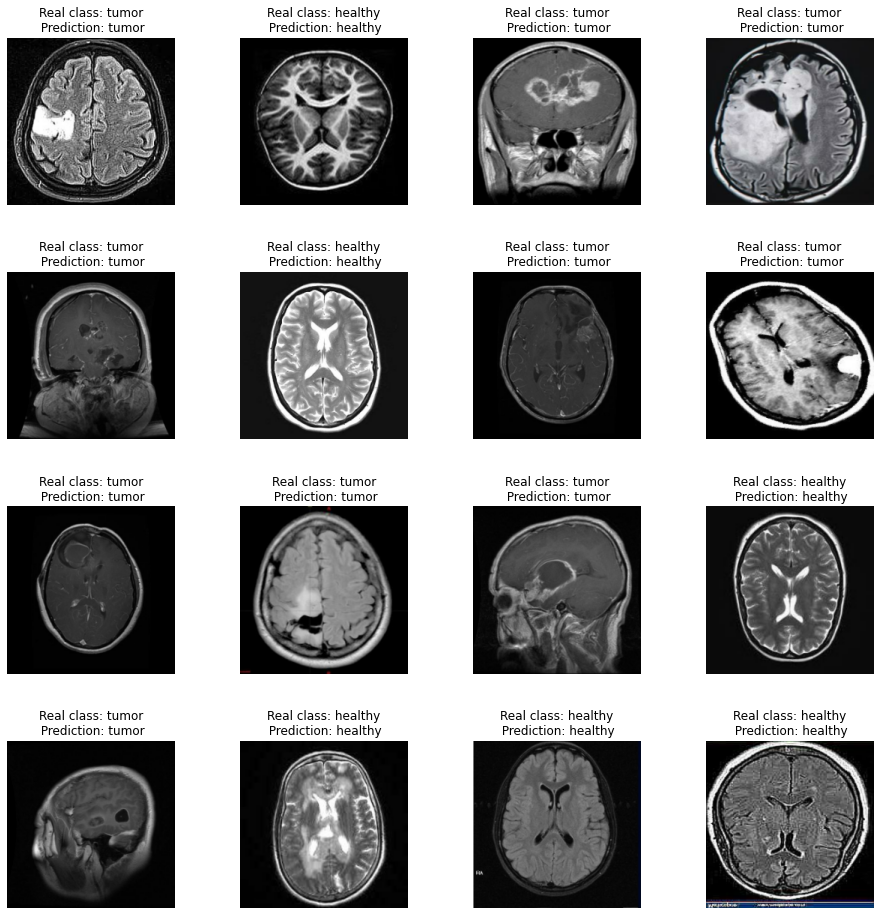

In [45]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [46]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

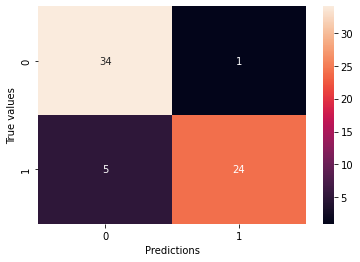

In [47]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [48]:
print(classification_report(y_val_3, y_pred_3_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.87      0.97      0.92        35
     Healthy       0.96      0.83      0.89        29

    accuracy                           0.91        64
   macro avg       0.92      0.90      0.90        64
weighted avg       0.91      0.91      0.91        64



## Inception_v3 - simple model

In [49]:
input_shape = (256, 256, 3)

In [50]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_4 = tf.keras.Sequential(
    [
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='simple_inception'
)

model_4.summary()

Model: "simple_inception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [51]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [52]:
epochs = 100
patience = 5

In [53]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 802s 13s/step - loss: 1.7598 - binary_accuracy: 0.6106 - val_loss: 1.5100 - val_binary_accuracy: 0.6261
Epoch 2/100
58/58 [==============================] - 765s 13s/step - loss: 1.1092 - binary_accuracy: 0.6837 - val_loss: 0.7192 - val_binary_accuracy: 0.7793
Epoch 3/100
58/58 [==============================] - 767s 13s/step - loss: 0.7790 - binary_accuracy: 0.7402 - val_loss: 0.7197 - val_binary_accuracy: 0.7489
Epoch 4/100
58/58 [==============================] - 769s 13s/step - loss: 0.6573 - binary_accuracy: 0.7636 - val_loss: 0.6226 - val_binary_accuracy: 0.7739
Epoch 5/100
58/58 [==============================] - 769s 13s/step - loss: 0.5451 - binary_accuracy: 0.7918 - val_loss: 0.6902 - val_binary_accuracy: 0.7707
Epoch 6/100
58/58 [==============================] - 768s 13s/step - loss: 0.5506 - binary_accuracy: 0.7937 - val_loss: 0.6533 - val_binary_accuracy: 0.7913
Epoch 7/100
58/58 [==============================] - 769s 

In [54]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

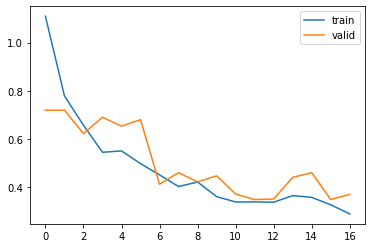

In [55]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

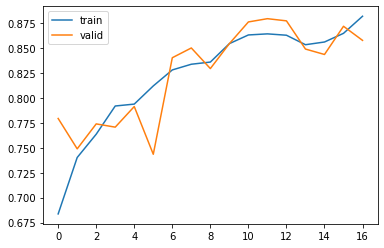

In [56]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [57]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.84375

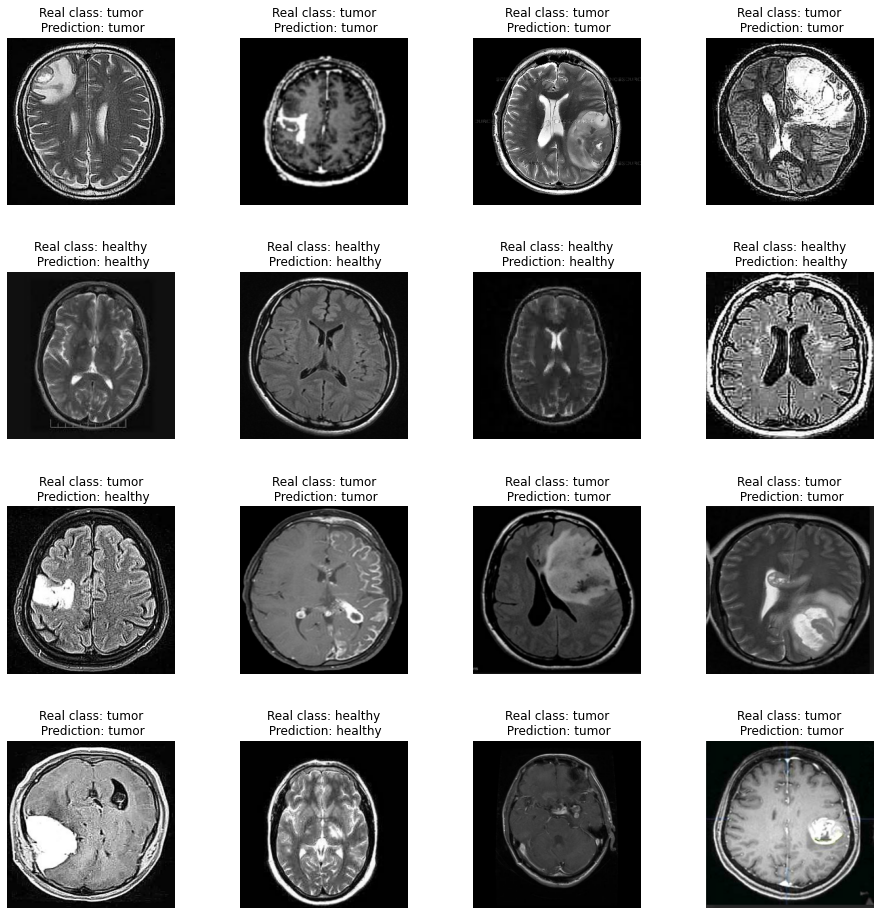

In [58]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [59]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

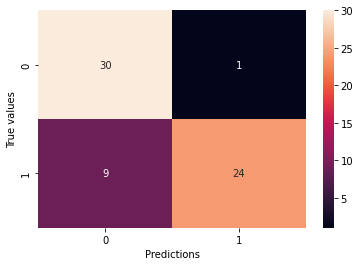

In [60]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [61]:
print(classification_report(y_val_4, y_pred_4_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.77      0.97      0.86        31
     Healthy       0.96      0.73      0.83        33

    accuracy                           0.84        64
   macro avg       0.86      0.85      0.84        64
weighted avg       0.87      0.84      0.84        64



## Inception_v3 model - with data augmentation

In [62]:
input_shape = (256, 256, 3)

In [63]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_5 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='inception_with_augmentation'
)

model_5.summary()

Model: "inception_with_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_2 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [64]:
model_5.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [65]:
epochs = 100
patience = 5

In [66]:
history_5 = model_5.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 498s 9s/step - loss: 2.1493 - binary_accuracy: 0.5867 - val_loss: 0.9712 - val_binary_accuracy: 0.6924
Epoch 2/100
58/58 [==============================] - 497s 9s/step - loss: 1.2300 - binary_accuracy: 0.6582 - val_loss: 0.7883 - val_binary_accuracy: 0.7326
Epoch 3/100
58/58 [==============================] - 452s 8s/step - loss: 1.0935 - binary_accuracy: 0.6641 - val_loss: 0.7213 - val_binary_accuracy: 0.7272
Epoch 4/100
58/58 [==============================] - 418s 7s/step - loss: 0.9896 - binary_accuracy: 0.6761 - val_loss: 0.6808 - val_binary_accuracy: 0.7413
Epoch 5/100
58/58 [==============================] - 412s 7s/step - loss: 0.8487 - binary_accuracy: 0.7133 - val_loss: 0.5968 - val_binary_accuracy: 0.7663
Epoch 6/100
58/58 [==============================] - 424s 7s/step - loss: 0.7451 - binary_accuracy: 0.7280 - val_loss: 0.5838 - val_binary_accuracy: 0.7620
Epoch 7/100
58/58 [==============================] - 424s 7s/ste

In [67]:
history_5.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

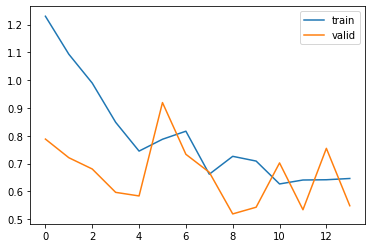

In [68]:
plt.plot(history_5.history['loss'][1:])
plt.plot(history_5.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

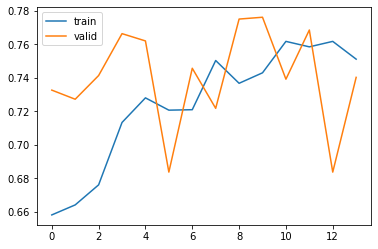

In [69]:
plt.plot(history_5.history['binary_accuracy'][1:])
plt.plot(history_5.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [70]:
x_val_5, y_val_5 = list(tfds.as_numpy(ds_val))[0]
y_pred_5 = model_5.predict(x_val_5)
sum((y_pred_5[:, 0] > 0) == y_val_5) / len(y_val_5)

0.71875

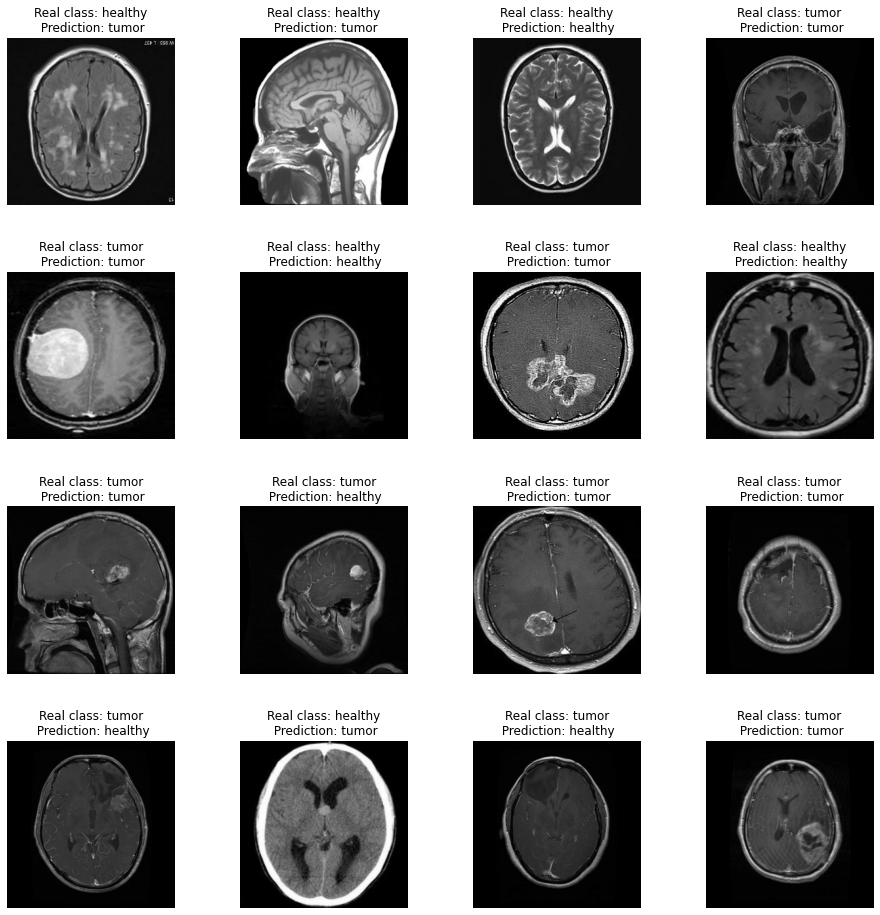

In [71]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_5[i].astype('int32'))
    
    real_y = 'healthy' if y_val_5[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_5[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [72]:
y_pred_5_binary = [1 if y > 0 else 0 for y in y_pred_5]

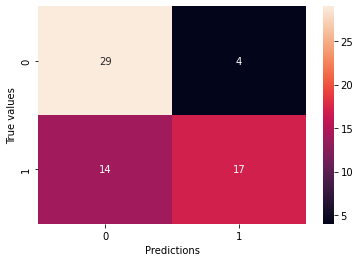

In [73]:
cf = tf.math.confusion_matrix(y_val_5, y_pred_5_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [74]:
print(classification_report(y_val_5, y_pred_5_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.67      0.88      0.76        33
     Healthy       0.81      0.55      0.65        31

    accuracy                           0.72        64
   macro avg       0.74      0.71      0.71        64
weighted avg       0.74      0.72      0.71        64



## Inception_v3 - model with data augmentation + additional dense layer

In [75]:
input_shape = (256, 256, 3)

In [76]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_6 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='inception_with_additional_dense'
)

model_6.summary()

Model: "inception_with_additional_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_3 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_3 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 320)               655680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None,

In [77]:
model_6.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [78]:
epochs = 100
patience = 5

In [79]:
history_6 = model_6.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 457s 8s/step - loss: 16.6437 - binary_accuracy: 0.5921 - val_loss: 3.5032 - val_binary_accuracy: 0.6783
Epoch 2/100
58/58 [==============================] - 492s 9s/step - loss: 4.9206 - binary_accuracy: 0.6644 - val_loss: 9.9979 - val_binary_accuracy: 0.5859
Epoch 3/100
58/58 [==============================] - 487s 8s/step - loss: 5.2694 - binary_accuracy: 0.6715 - val_loss: 2.9922 - val_binary_accuracy: 0.7098
Epoch 4/100
58/58 [==============================] - 487s 8s/step - loss: 6.4513 - binary_accuracy: 0.6508 - val_loss: 2.5838 - val_binary_accuracy: 0.7543
Epoch 5/100
58/58 [==============================] - 487s 8s/step - loss: 3.0636 - binary_accuracy: 0.7253 - val_loss: 1.4516 - val_binary_accuracy: 0.7783
Epoch 6/100
58/58 [==============================] - 488s 8s/step - loss: 2.1883 - binary_accuracy: 0.7391 - val_loss: 1.3694 - val_binary_accuracy: 0.7696
Epoch 7/100
58/58 [==============================] - 496s 9s/st

In [80]:
history_6.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

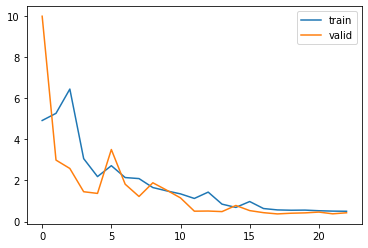

In [81]:
plt.plot(history_6.history['loss'][1:])
plt.plot(history_6.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

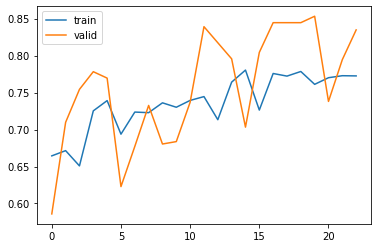

In [82]:
plt.plot(history_6.history['binary_accuracy'][1:])
plt.plot(history_6.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [83]:
x_val_6, y_val_6 = list(tfds.as_numpy(ds_val))[0]
y_pred_6 = model_6.predict(x_val_6)
sum((y_pred_6[:, 0] > 0) == y_val_6) / len(y_val_6)

0.84375

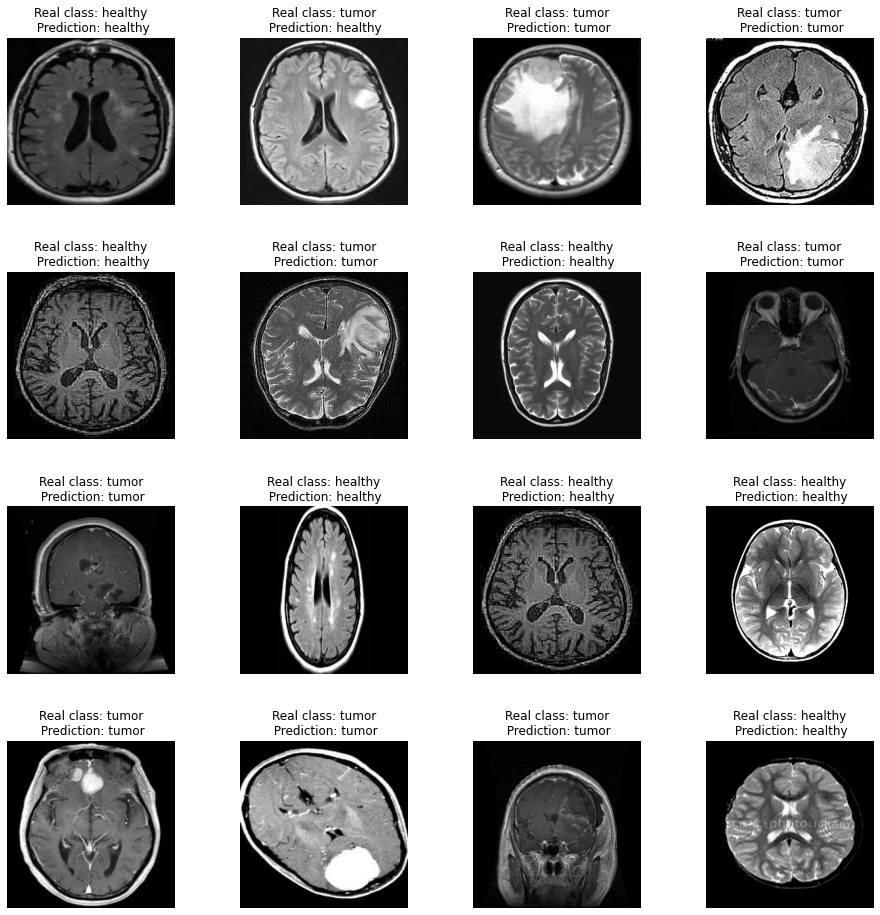

In [84]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_6[i].astype('int32'))
    
    real_y = 'healthy' if y_val_6[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_6[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [85]:
y_pred_6_binary = [1 if y > 0 else 0 for y in y_pred_6]

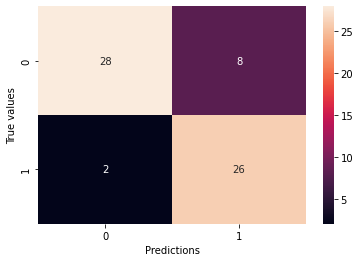

In [86]:
cf = tf.math.confusion_matrix(y_val_6, y_pred_6_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [87]:
print(classification_report(y_val_6, y_pred_6_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.93      0.78      0.85        36
     Healthy       0.76      0.93      0.84        28

    accuracy                           0.84        64
   macro avg       0.85      0.85      0.84        64
weighted avg       0.86      0.84      0.84        64

